<a href="https://colab.research.google.com/github/zhus-dika/railways_caclulations/blob/main/railways_calculations_regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐫 Realize regression model

## 🦀 Download data

### 🪰 Install need packages

In [1]:
# ! apt install x13as
! pip install pyexcel pyexcel-xls pyexcel-xlsx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 5.8 MB/s eta 0:00:00


### 🐳 Imports

In [2]:
import pandas as pd
import statsmodels.api as sm
import gdown
from datetime import datetime
import math

from openpyxl import load_workbook

import matplotlib.pyplot as plt

### 🐻‍❄️ Useful methods

In [3]:
def construct_serial_data_by_type(type, df, dct_serial):
  dates = [datetime.strptime(i, '%y-%m') for i in df.columns]
  serial_dates = {i: [] for i in dct_serial[type]}
  for idx, date in enumerate(dates):
    for key, value in serial_dates.items():
      dt = datetime.strptime(key[3:5]+'-'+key[-2:], '%y-%m')
      if date == dt:
        serial_dates[key].append(1)
      else:
        serial_dates[key].append(0)
  return serial_dates

In [4]:
start = 2002
end = 2017

def excel_columns(n):
    columns = []
    for i in range(1, n + 1):
        col = ""
        num = i
        while num > 0:
            num -= 1
            col = chr(65 + (num % 26)) + col
            num //= 26
        columns.append(col)
    return columns

column_names = excel_columns(14 * (end - start + 1))

In [5]:
def fill_transportation_tariffs(table_data, start, end):
  commodities_transportation_tariffs = {datetime.strptime(str(year) + '-' + str(i), '%Y-%m').strftime("%y-%m"): [] for year in range(start, end + 1) for i in range(1, 13)}
  commodities_transportation_tariffs['name'] = []
  name_column = 'A'
  for i in range(1, 82):
    if i % 4 == 0:
      value = table_data[name_column+str(i)].value
      value = value.replace(',', ' ').replace('.', ' ').replace(')', ' ').replace('(', ' ').replace('-', ' ').replace('из ', ' ').replace(' нее:', ' ').replace(' него:', ' ').replace(' них:', ' ').replace("\n", " ").lower()
      name = " ".join(value.split())
      commodities_transportation_tariffs['name'].append(name)

      for column_num in range((end - start + 1) * 12):
        val_volume = table_data[column_names[column_num + 2 + math.floor(column_num / 12)] + str(i + 1)].value
        commodities_transportation_tariffs[datetime.strptime(str(start + math.floor(column_num / 12))  + '-' + str(column_num % 12 + 1), '%Y-%m').strftime("%y-%m")].append(val_volume)
  return commodities_transportation_tariffs

In [6]:
def plot_regression_results(model, df):
  df["fitted"] = model.fittedvalues
  df["residuals"] = model.resid

  # Plot of actual, predicted, and residual values
  fig, ax1 = plt.subplots(figsize=(20, 10))

  # Actual and predicted lines
  ax1.plot(df.index, df["Y"], color="red", label="Actual")
  ax1.plot(df.index, df["fitted"], color="green", label="Fitted")

  # Second axis for residuals
  ax2 = ax1.twinx()
  ax2.plot(df.index, df["residuals"], color="blue", label="Residual", alpha=0.7)

  # Add a horizontal line at level 0 for residuals
  ax2.axhline(0, linestyle="--", color="black", linewidth=0.8)

  ax1.legend(loc="upper right")
  ax2.legend(loc="lower right")

  # Axis titles
  ax1.set_xlabel("Date")
  ax1.set_ylabel("Actual & Fitted")
  ax2.set_ylabel("Residuals")

  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45, fontsize=6)
  #ax2.set_xticklabels(ax2.get_xticks(), rotation = 45, fontsize=6)
  plt.title("Actual, Fitted, and Residuals Plot")
  plt.show()

### 🐟 Read data

🐺 Getting indexed adjustment volumes data

In [7]:
url = "https://drive.google.com/uc?id=1nv0pPe2E1NQRzZF-pHHZkTT71CTHc68R"
volumes = 'volumes.xlsx'
gdown.download(url, volumes, quiet=False);


df_volumes = pd.read_excel('volumes.xlsx', index_col='type')

Downloading...
From: https://drive.google.com/uc?id=1nv0pPe2E1NQRzZF-pHHZkTT71CTHc68R
To: /content/volumes.xlsx
100%|██████████| 107k/107k [00:00<00:00, 17.8MB/s]


In [8]:
df_volumes = df_volumes.rename(columns={date: date.strftime('%y-%m') for date in df_volumes.columns})

In [9]:
df_volumes.sample(5)

03-01     03-02     03-03     03-04     03-05     03-06  \
type                                                                         
Earth_adjusted  1.480096  1.341166  1.593846  1.416560  1.268244  1.369066   
Petrol          1.138979  1.417636  1.108844  1.316228  1.570009  1.116814   
Lim_adjusted    1.243567  1.161781  1.088058  1.209383  1.083081  1.137478   
Coal            1.149409  1.127601  1.534823  1.554613  1.244032  1.396526   
nFerr           0.972207  1.007611  1.002024  0.984602  1.011958  0.953884   

                   03-07     03-08     03-09     03-10  ...     24-03  \
type                                                    ...             
Earth_adjusted  1.127882  1.321687  1.247020  1.069717  ...  1.441272   
Petrol          1.032895  1.273515  1.188273  0.889481  ...  1.054265   
Lim_adjusted    0.964124  0.961124  1.191410  1.389540  ...  1.177135   
Coal            1.146947  0.862378  0.858023  1.048863  ...  0.949497   
nFerr           0.984933  0.927702  0.968358  1.012275  ...  0.892293   

                   24-04     24-05     24-06     24-07     24-08     24-09  \
type                                                                         
Earth_adjusted  1.358307  0.984517  0.884685  1.261208  1.014213  1.085913   
Petrol          0.784654  0.959959  1.000923  1.335527  1.006773  1.007882   
Lim_adjusted    1.152923  1.039607  0.994984  0.985720  0.917058  0.757069   
Coal            0.903377  0.885861  0.863684  0.989411  0.991784  1.039864   
nFerr           0.986672  1.013474  0.982458  1.017588  0.998086  0.981333   

                   24-10     24-11     24-12  
type                                          
Earth_adjusted  1.299039  1.390387  1.776400  
Petrol          1.039107  1.075208  1.106746  
Lim_adjusted    0.972525  1.116322  1.017416  
Coal            0.997572  1.069246  1.043178  
nFerr           0.987121  0.941258  0.988864  

[5 rows x 264 columns]

🦐 Filter only adjusted rows

In [10]:
adjusted_rows = [i for i in df_volumes.index if len(i.split('_')) > 1]

mask = df_volumes.index.isin(adjusted_rows)
df_volumes = df_volumes[mask]

In [11]:
df_volumes.sample(5)

03-01     03-02     03-03     03-04     03-05     03-06  \
type                                                                          
nFerr_adjusted   0.988432  1.000357  0.983268  0.977983  1.005570  0.946232   
Cement_adjusted  1.147336  1.102376  0.892257  0.905910  1.308594  1.430011   
Earth_adjusted   1.480096  1.341166  1.593846  1.416560  1.268244  1.369066   
Black_adjusted   1.107154  1.032615  1.036182  1.121432  0.964139  1.101222   
Lim_adjusted     1.243567  1.161781  1.088058  1.209383  1.083081  1.137478   

                    03-07     03-08     03-09     03-10  ...     24-03  \
type                                                     ...             
nFerr_adjusted   0.984209  0.950758  0.979675  1.010900  ...  0.884406   
Cement_adjusted  1.325809  1.229607  1.270885  1.222293  ...  0.818200   
Earth_adjusted   1.127882  1.321687  1.247020  1.069717  ...  1.441272   
Black_adjusted   1.080336  1.071287  1.114400  1.020916  ...  1.094561   
Lim_adjusted     0.964124  0.961124  1.191410  1.389540  ...  1.177135   

                    24-04     24-05     24-06     24-07     24-08     24-09  \
type                                                                          
nFerr_adjusted   0.989413  1.034805  0.985319  0.993452  1.000949  0.989031   
Cement_adjusted  1.018180  0.966344  0.968121  1.033922  1.064140  1.089983   
Earth_adjusted   1.358307  0.984517  0.884685  1.261208  1.014213  1.085913   
Black_adjusted   1.033828  1.148415  1.132755  1.118854  1.101313  1.001237   
Lim_adjusted     1.152923  1.039607  0.994984  0.985720  0.917058  0.757069   

                    24-10     24-11     24-12  
type                                           
nFerr_adjusted   0.995625  0.950038  0.989594  
Cement_adjusted  0.983672  0.948599  1.083497  
Earth_adjusted   1.299039  1.390387  1.776400  
Black_adjusted   1.074308  1.052041  1.079446  
Lim_adjusted     0.972525  1.116322  1.017416  

[5 rows x 264 columns]

In [12]:
df_volumes.index = [i.split('_')[0] for i in df_volumes.index]

In [13]:
df_volumes.sample(5)

03-01     03-02     03-03     03-04     03-05     03-06     03-07  \
nFerr   0.988432  1.000357  0.983268  0.977983  1.005570  0.946232  0.984209   
Iron    1.196323  1.137040  1.090749  1.076335  1.193487  1.106854  1.280330   
Wheat   1.405050  1.335464  1.243198  1.222072  1.201595  1.164400  1.046377   
Drinks  1.058928  1.010184  1.019816  1.107321  1.055743  1.131114  1.126587   
Chem    0.947980  0.922180  0.988208  0.319391  0.741968  0.785920  0.647708   

           03-08     03-09     03-10  ...     24-03     24-04     24-05  \
nFerr   0.950758  0.979675  1.010900  ...  0.884406  0.989413  1.034805   
Iron    1.251372  1.314330  1.248365  ...  1.350003  1.142641  1.207504   
Wheat   0.921651  0.984873  0.996572  ...  0.984923  0.906323  1.012457   
Drinks  1.173688  1.274232  1.168759  ...  0.983818  1.005387  1.021985   
Chem    0.915157  1.108482  1.343730  ...  1.164998  1.193062  1.096665   

           24-06     24-07     24-08     24-09     24-10     24-11     24-12  
nFerr   0.985319  0.993452  1.000949  0.989031  0.995625  0.950038  0.989594  
Iron    1.233599  1.122828  1.392767  1.229503  1.179020  1.171365  0.987085  
Wheat   1.108902  0.909788  1.013309  1.064729  1.063984  0.962319  1.089922  
Drinks  1.021990  1.050561  1.015551  1.034032  1.077381  1.032528  1.125397  
Chem    1.289898  0.753116  1.005912  1.112207  0.989660  1.401184  1.106079  

[5 rows x 264 columns]

🐤 Getting indexed adjustment transportation volumes data

In [14]:
url = "https://drive.google.com/uc?id=1jzuze4gNQkryG2up3ruFI19LoASI14X9"
transportation_volumes = 'transportation_volumes.xlsx'
gdown.download(url, transportation_volumes, quiet=False);


df_transportation_volumes = pd.read_excel(transportation_volumes, index_col='type')

Downloading...
From: https://drive.google.com/uc?id=1jzuze4gNQkryG2up3ruFI19LoASI14X9
To: /content/transportation_volumes.xlsx
100%|██████████| 67.8k/67.8k [00:00<00:00, 14.8MB/s]


In [15]:
df_transportation_volumes = df_transportation_volumes.rename(columns={date: date.strftime('%y-%m') for date in df_transportation_volumes.columns})

In [16]:
df_transportation_volumes.head()

03-01     03-02     03-03     03-04     03-05     03-06     03-07  \
type                                                                           
Coal    1.146989  1.271296  2.001057  1.617007  1.497430  2.758001  1.602998   
Iron    1.412507  1.134848  1.154288  1.236893  1.152850  1.289855  1.010562   
Oil     1.001428  0.888155  0.881444  1.181056  1.216150  0.812597  0.862972   
Petrol  1.284108  1.637060  1.612777  1.293651  1.817554  1.618301  1.407716   
Scrap   0.678691  0.532579  1.807040  1.914268  1.586697  0.737438  1.703007   

           03-08     03-09     03-10  ...     17-03     17-04     17-05  \
type                                  ...                                 
Coal    0.851024  0.779384  0.822710  ...  1.299334  1.142139  1.127997   
Iron    1.016424  1.126092  1.041267  ...  1.027275  1.132663  1.022012   
Oil     0.754016  0.798269  0.892205  ...  1.176338  0.807852  0.602213   
Petrol  1.418118  1.159494  1.268705  ...  1.318899  0.804209  0.999319   
Scrap   0.809680  1.254796  0.951983  ...  1.519347  1.133832  1.079397   

           17-06     17-07     17-08     17-09     17-10     17-11     17-12  
type                                                                          
Coal    1.232185  1.185096  1.113000  0.890330  0.961143  1.088174  0.912056  
Iron    1.012473  1.244028  1.367165  1.146183  1.374477  1.153021  0.979902  
Oil     0.568115  0.555227  0.526765  0.670949  0.827540  0.679410  0.432077  
Petrol  0.876377  1.012419  0.888688  0.895795  1.082105  1.182459  1.007365  
Scrap   0.991456  1.032845  1.302089  1.657707  1.855247  1.647698  0.938190  

[5 rows x 180 columns]

In [17]:
df_volumes = df_volumes[df_transportation_volumes.columns]
df_volumes.sample(5)

03-01     03-02     03-03     03-04     03-05     03-06     03-07  \
ColOre  1.170649  1.088629  1.004364  1.007313  1.017305  1.066902  0.999734   
Cement  1.147336  1.102376  0.892257  0.905910  1.308594  1.430011  1.325809   
Earth   1.480096  1.341166  1.593846  1.416560  1.268244  1.369066  1.127882   
nFerr   0.988432  1.000357  0.983268  0.977983  1.005570  0.946232  0.984209   
Wheat   1.405050  1.335464  1.243198  1.222072  1.201595  1.164400  1.046377   

           03-08     03-09     03-10  ...     17-03     17-04     17-05  \
ColOre  1.022211  0.980279  0.944664  ...  1.232864  1.192358  1.253334   
Cement  1.229607  1.270885  1.222293  ...  0.939902  0.904574  1.033900   
Earth   1.321687  1.247020  1.069717  ...  1.136441  1.054076  1.148303   
nFerr   0.950758  0.979675  1.010900  ...  0.950977  1.002541  0.915970   
Wheat   0.921651  0.984873  0.996572  ...  1.060310  0.918981  0.988572   

           17-06     17-07     17-08     17-09     17-10     17-11     17-12  
ColOre  1.195697  1.105047  1.199743  1.088386  1.055487  1.067826  1.049844  
Cement  1.085490  1.109421  1.212858  1.084345  1.179294  0.874172  0.852623  
Earth   1.106581  1.293102  2.288384  2.110025  0.972087  1.139557  1.020606  
nFerr   0.931438  1.014175  1.000366  0.963996  0.985940  0.992766  1.065422  
Wheat   1.016239  1.019465  1.078794  1.043480  0.909387  1.091635  1.048003  

[5 rows x 180 columns]

🦢 Filter only adjusted rows

In [18]:
adjusted_rows = [i for i in df_transportation_volumes.index if len(i.split('_')) > 1]

mask = df_transportation_volumes.index.isin(adjusted_rows)
df_transportation_volumes = df_transportation_volumes[mask]

In [19]:
df_transportation_volumes.index = [i.split('_')[0] for i in df_transportation_volumes.index]

In [20]:
df_transportation_volumes.sample(5)

03-01     03-02     03-03     03-04     03-05     03-06     03-07  \
Chem    1.317629  1.452880  1.710783  1.503417  1.553746  2.306077  2.998459   
Iron    1.318764  1.209237  1.083680  1.113407  1.030436  1.140144  1.158625   
Oil     1.055691  0.888278  0.905556  1.131349  1.113799  0.782867  0.872343   
Cement  1.765723  0.146209  1.623707  1.635688  1.012742  0.967791  0.992997   
Petrol  1.286750  1.594282  1.660985  1.353822  1.659154  1.601157  1.450395   

           03-08     03-09     03-10  ...     17-03     17-04     17-05  \
Chem    2.722478  2.703821  2.816517  ...  1.022553  1.124558  1.240480   
Iron    1.114622  1.170102  1.100939  ...  1.026488  1.145429  1.025656   
Oil     0.816795  0.865678  0.879591  ...  1.256835  0.771495  0.649785   
Cement  1.220212  0.832037  0.321688  ...  2.231768  1.905755  2.460746   
Petrol  1.537633  1.186031  1.220204  ...  1.401176  0.785781  1.016540   

           17-06     17-07     17-08     17-09     17-10     17-11     17-12  
Chem    1.197253  1.057434  1.058726  1.124419  1.074581  1.381308  1.180739  
Iron    1.026457  1.279608  1.349860  1.097593  1.371785  1.159362  0.961312  
Oil     0.581336  0.553317  0.501257  0.579954  0.804585  0.694120  0.487653  
Cement  1.610603  1.394241  1.261023  1.178586  1.230361  2.356786  2.663116  
Petrol  0.883565  1.015350  0.925979  0.911603  1.085788  1.104715  1.005676  

[5 rows x 180 columns]

🦧 Prepare SERial data

In [21]:
dct_serial = {
    #'Coal': ["SER0306", "SER0406", "SER1006", "SER1311", "SER1312", "SER1412", "SER1501", "SER1510", "SER1706"],
    'Coal': ["SER0306", "SER1006"],
    'Iron': ["SER0505", "SER0604", "SER0605", "SER0606", "SER0607", "SER0608", "SER0705", "SER0811", "SER0910", "SER0911", "SER0912", "SER1001", "SER1004", "SER1312", "SER1401", "SER1501", "SER1507", "SER1509", "SER1705", "SER1706", "SER1707"],
    'Oil': ["SER0402", "SER0409", "SER0601", "SER0602", "SER0603", "SER0608", "SER0610", "SER1207", "SER1208", "SER1311", "SER1404", "SER1607", "SER1703", "SER1708"],
    'Petrol': ["SER0405", "SER0510", "SER0706", "SER0912", "SER1009", "SER1212", "SER1401", "SER1501", "SER1505", "SER1603", "SER1604"],
    'Constr': ["SER0501", "SER0803", "SER0811", "SER1002", "SER1011", "SER1103", "SER1301", "SER1401", "SER1502", "SER1602", "SER170"],
    'Chem': ["SER0307", "SER0411", "SER0807", "SER0901", "SER0903", "SER0904", "SER0905", "SER0909", "SER0910", "SER0911", "SER1001", "SER1009", "SER1010", "SER1104", "SER1302", "SER1303", "SER1401", "SER1501", "SER1611"],
    'Black': ["SER0603", "SER1101", "SER1501", "SER1701"],
    'Cement': ["SER0411", "SER0501", "SER0808", "SER1001", "SER1004", "SER1006", "SER1007", "SER1008", "SER1011", "SER1312", "SER1501", "SER1701"],
    'Coke': ["SER0501", "SER0701", "SER0710", "SER0901", "SER1003", "SER1004", "SER1012", "SER1102", "SER1201", "SER1203", "SER1204", "SER1409", "SER1412", "SER1501", "SER1703", "SER1707"],
    'ColOre': ["SER0407", "SER0501", "SER0901", "SER1001", "SER1206", "SER1302", "SER1312", "SER1401", "SER1402", "SER1501", "SER1502", "SER1505", "SER1606"],
    'Corn': ["SER0603", "SER0604", "SER0611", "SER0708", "SER0906", "SER0908", "SER0909", "SER0910", "SER1104", "SER1201", "SER1203", "SER1208", "SER1209", "SER1210", "SER1501", "SER1507"],
    'Drinks': ["SER0401", "SER0508", "SER0701", "SER0801", "SER1009", "SER1104", "SER1306", "SER1312", "SER1401", "SER1501", "SER1509"],
    'Earth': ["SER0401", "SER0503", "SER0704", "SER0710", "SER0812", "SER0903", "SER1002", "SER1101", "SER1301", "SER1401", "SER1403", "SER1501", "SER1503", "SER1505", "SER1701"],
    'Fert': ["SER0409", "SER0510", "SER0511", "SER0702", "SER0810", "SER1010", "SER1011", "SER1107", "SER1201", "SER1710"],
    'Lim': ["SER0702", "SER1002", "SER1003", "SER1010", "SER1011", "SER1102", "SER1312", "SER1401", "SER1501", "SER1701", "SER1711"],
    'nFerr': ["SER0405", "SER0406", "SER0511", "SER0602", "SER0603", "SER0704", "SER0709", "SER0806", "SER0810", "SER0906", "SER0912", "SER1001", "SER1004", "SER1005", "SER1207", "SER1401", "SER1405", "SER1412", "SER1501", "SER1504", "SER1601", "SER1709", "SER1710", "SER1712"],
    'Other': ["SER0912", "SER1007", "SER1012", "SER1312", "SER1401", "SER1501"],
    'Scrap': ["SER0401", "SER0404", "SER0405", "SER0406", "SER0407", "SER0411", "SER0603", "SER0604", "SER0810", "SER0910", "SER0911", "SER0912", "SER1101", "SER1111", "SER1502", "SER1606", "SER1608", "SER1701", "SER1702"],
    'Slag': ["SER0402", "SER0704", "SER0705", "SER0707", "SER0708", "SER0911", "SER1001", "SER1101", "SER1102", "SER1109", "SER1110", "SER1511", "SER1601", "SER1612"],
    'Wheat': ["SER0806", "SER0912", "SER1201", "SER1403"]
}

🦑 Prepare indexed tariff data

In [59]:
url = "https://drive.google.com/uc?id=1BtFPuxKd6XAhILhfeesl5QnWgZ8o5roO"
tariff = 'tariff.xlsx'
gdown.download(url, tariff, quiet=False);

Downloading...
From: https://drive.google.com/uc?id=1BtFPuxKd6XAhILhfeesl5QnWgZ8o5roO
To: /content/tariff.xlsx
100%|██████████| 2.20M/2.20M [00:00<00:00, 72.2MB/s]


In [60]:
wb = load_workbook(tariff)

main_sheet = 'Тариф'
commodities_transportation_tariffs = {}

In [61]:
end = 2024
column_names = excel_columns(14 * (end - start + 1))

commodities_transportation_tariffs =  fill_transportation_tariffs(wb[main_sheet], start, end)

In [62]:
df_transportation_tariff = pd.DataFrame(commodities_transportation_tariffs)

In [63]:
df_transportation_tariff.head()

02-01  02-02  02-03  02-04  02-05  02-06  02-07  02-08  02-09  02-10  ...  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   

   24-04  24-05  24-06  24-07  24-08  24-09  24-10  24-11  24-12  \
0    0.0    0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   
1    0.0    0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   
2    0.0    0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   
3    0.0    0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   
4    0.0    0.0    8.8    0.0    0.0    0.0    0.0    0.0    7.8   

                 name  
0               уголь  
1       железная руда  
2         нефть сырая  
3       нефтепродукты  
4  строительные грузы  

[5 rows x 277 columns]

In [64]:
dct_names = {'Coal': 'Уголь',
            'Iron': 'Железная руда',
            'Earth': 'Земля, песок, глина и камни природные',
            'Lim': 'Известняк для флюсования',
            'Coke': 'Кокс каменноугольный',
            'Black': 'Чер. металлы',
            'Scrap': 'Лом черных металлов',
            'Wheat': 'Мука пшеничная',
            'Oil': 'Нефть сырая',
            'Petrol': 'Нефтепродукты',
            'Drinks': 'Соки и напитки',
            'Fert': 'Хим. и мин. удобрения',
            'nFerr': 'Цвет. металлы',
            'ColOre': 'Цветная руда',
            'Chem': 'Химикаты и сода',
            'Cement': 'Цемент'
            }

In [65]:
for key in dct_names.keys():
  dct_names[key] = " ".join(dct_names[key].replace(',', ' ').replace('.', ' ').replace(')', ' ').replace('(', ' ').replace('-', ' ').lower().split())

In [66]:
common_names = set(dct_names.keys()) & set(df_volumes.index)

### 🐛 Getting world prices from worldbank data

In [30]:
url = "https://drive.google.com/uc?id=1unmLzZqNao62p_3wANVrrHBAQ9jDn5no"
worldbank_commodity_prices_monthly = 'worldbank_commodity_prices_monthly.xlsx'
gdown.download(url, worldbank_commodity_prices_monthly, quiet=False);

Downloading...
From: https://drive.google.com/uc?id=1unmLzZqNao62p_3wANVrrHBAQ9jDn5no
To: /content/worldbank_commodity_prices_monthly.xlsx
100%|██████████| 767k/767k [00:00<00:00, 38.4MB/s]


### Select data with common names

In [31]:
df_volumes = df_volumes[df_volumes.index.isin(common_names)]

df_transportation_volumes = df_transportation_volumes[df_transportation_volumes.index.isin(common_names)]

In [32]:
df_transportation_tariff['type'] = ''

for idx, row in df_transportation_tariff.iterrows():
  for key in dct_names.keys():
    if dct_names[key] == row['name']:
      df_transportation_tariff.loc[idx, 'type'] = key

In [33]:
df_transportation_tariff.sample(5)

02-01  02-02  02-03  02-04  02-05  02-06  02-07  02-08  02-09  02-10  ...  \
2     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   
17    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   
3     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   
18    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   
16    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   

    17-05  17-06  17-07  17-08  17-09  17-10  17-11  17-12  \
2     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
17    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
18    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
16    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                     name    type  
2             нефть сырая     Oil  
17   кокс каменноугольный    Coke  
3           нефтепродукты  Petrol  
18  шлаки гранулированные          
16         мука пшеничная   Wheat  

[5 rows x 194 columns]

In [34]:
df_transportation_tariff = df_transportation_tariff[df_transportation_tariff['type'].isin(common_names)]

In [35]:
df_transportation_tariff.sample(5)

02-01  02-02  02-03  02-04  02-05  02-06  02-07  02-08  02-09  02-10  ...  \
2     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   
17    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   
1     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   
0     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
3     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0  ...   

    17-05  17-06  17-07  17-08  17-09  17-10  17-11  17-12  \
2     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
17    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
0     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                    name    type  
2            нефть сырая     Oil  
17  кокс каменноугольный    Coke  
1          железная руда    Iron  
0                  уголь    Coal  
3          нефтепродукты  Petrol  

[5 rows x 194 columns]

In [36]:
df_transportation_tariff.set_index('type', inplace=True)

In [37]:
df_transportation_tariff.sample(5)

02-01  02-02  02-03  02-04  02-05  02-06  02-07  02-08  02-09  02-10  \
type                                                                          
Lim      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0   
Coke     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0   
nFerr    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0   
Coal     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Scrap    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.0   

       ...  17-04  17-05  17-06  17-07  17-08  17-09  17-10  17-11  17-12  \
type   ...                                                                  
Lim    ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Coke   ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
nFerr  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Coal   ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Scrap  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                           name  
type                             
Lim    известняк для флюсования  
Coke       кокс каменноугольный  
nFerr              цвет металлы  
Coal                      уголь  
Scrap       лом черных металлов  

[5 rows x 193 columns]

🐰 Convert all data 2 float

In [38]:
for column_num in df_transportation_tariff.columns:
  if column_num != 'name':
      df_transportation_tariff[column_num] = df_transportation_tariff[column_num].astype(float)
      df_transportation_tariff[column_num] = df_transportation_tariff[column_num] / 100 + 1.0

In [39]:
df_transportation_tariff.sample(5)

02-01  02-02  02-03  02-04  02-05  02-06  02-07  02-08  02-09  02-10  \
type                                                                           
Coal      1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.00   
ColOre    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Oil       1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Wheat     1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Black     1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   

        ...  17-04  17-05  17-06  17-07  17-08  17-09  17-10  17-11  17-12  \
type    ...                                                                  
Coal    ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
ColOre  ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
Oil     ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
Wheat   ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
Black   ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   

                  name  
type                    
Coal             уголь  
ColOre    цветная руда  
Oil        нефть сырая  
Wheat   мука пшеничная  
Black      чер металлы  

[5 rows x 193 columns]

🦓 Filter years from 2003

In [40]:
df_transportation_tariff

02-01  02-02  02-03  02-04  02-05  02-06  02-07  02-08  02-09  02-10  \
type                                                                           
Coal      1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.00   
Iron      1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Oil       1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Petrol    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Scrap     1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Chem      1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Fert      1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
ColOre    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
nFerr     1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Black     1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Cement    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Lim       1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Earth     1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Wheat     1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Coke      1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   
Drinks    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   1.02   

        ...  17-04  17-05  17-06  17-07  17-08  17-09  17-10  17-11  17-12  \
type    ...                                                                  
Coal    ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
Iron    ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
Oil     ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
Petrol  ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
Scrap   ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
Chem    ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
Fert    ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
ColOre  ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
nFerr   ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
Black   ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
Cement  ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
Lim     ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
Earth   ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
Wheat   ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
Coke    ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
Drinks  ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   

                                       name  
type                                         
Coal                                  уголь  
Iron                          железная руда  
Oil                             нефть сырая  
Petrol                        нефтепродукты  
Scrap                   лом черных металлов  
Chem                        химикаты и сода  
Fert                    хим и мин удобрения  
ColOre                         цветная руда  
nFerr                          цвет металлы  
Black                           чер металлы  
Cement                               цемент  
Lim                известняк для флюсования  
Earth   земля песок глина и камни природные  
Wheat                        мука пшеничная  
Coke                   кокс каменноугольный  
Drinks                       соки и напитки  

[16 rows x 193 columns]

In [41]:
df_transportation_tariff = df_transportation_tariff[df_transportation_volumes.columns]

In [42]:
df_transportation_tariff.loc['Coal', '10-01']

1.2153

## 🦚 Run regression model

### 🦤 Prepare data to model

In [43]:
commodity_type = 'Coal'

type_dct = {
    "Y": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
    "T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
    "X": df_volumes.loc[commodity_type]   # Production growth index
}
# dummy variables
dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
for key, value in dct_serial_data.items():
  type_dct[key] = value
df_type = pd.DataFrame(type_dct)

In [44]:
df_type.sample(5)

Y    T         X  SER0306  SER1006
11-08  1.139801  1.0  1.088684        0        0
17-09  0.856009  1.0  1.041246        0        0
08-09  1.063728  1.0  1.055216        0        0
16-06  1.003327  1.0  1.230554        0        0
15-10  0.997869  1.0  0.965873        0        0

🐂 Add lag

In [45]:
df_type["Y_lag"] = df_type["Y"].shift(1)

In [46]:
df_type.sample(5)

Y    T         X  SER0306  SER1006     Y_lag
09-08  0.753677  1.0  0.955561        0        0  0.815136
07-05  1.077418  1.0  0.936104        0        0  0.834147
05-04  0.910782  1.0  1.012468        0        0  1.026025
03-08  0.855391  1.0  0.871470        0        0  1.675245
11-10  1.060232  1.0  1.052996        0        0  1.004026

In [47]:
df_type = df_type.dropna()

In [48]:
Y = df_type["Y"]
X = df_type[[i for i in df_type.columns if i != 'Y']]

# Adding a constant for regression
X = sm.add_constant(X)

# Make regression
model = sm.OLS(Y, X).fit()

# Print results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     129.0
Date:                Tue, 18 Feb 2025   Prob (F-statistic):           1.94e-56
Time:                        05:33:01   Log-Likelihood:                 96.397
No. Observations:                 179   AIC:                            -180.8
Df Residuals:                     173   BIC:                            -161.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3685      0.367     -1.005      0.3

### 🐮 Run all types

In [49]:
import warnings
warnings.filterwarnings("ignore")

**********************************************************************************
commodity type: Coal


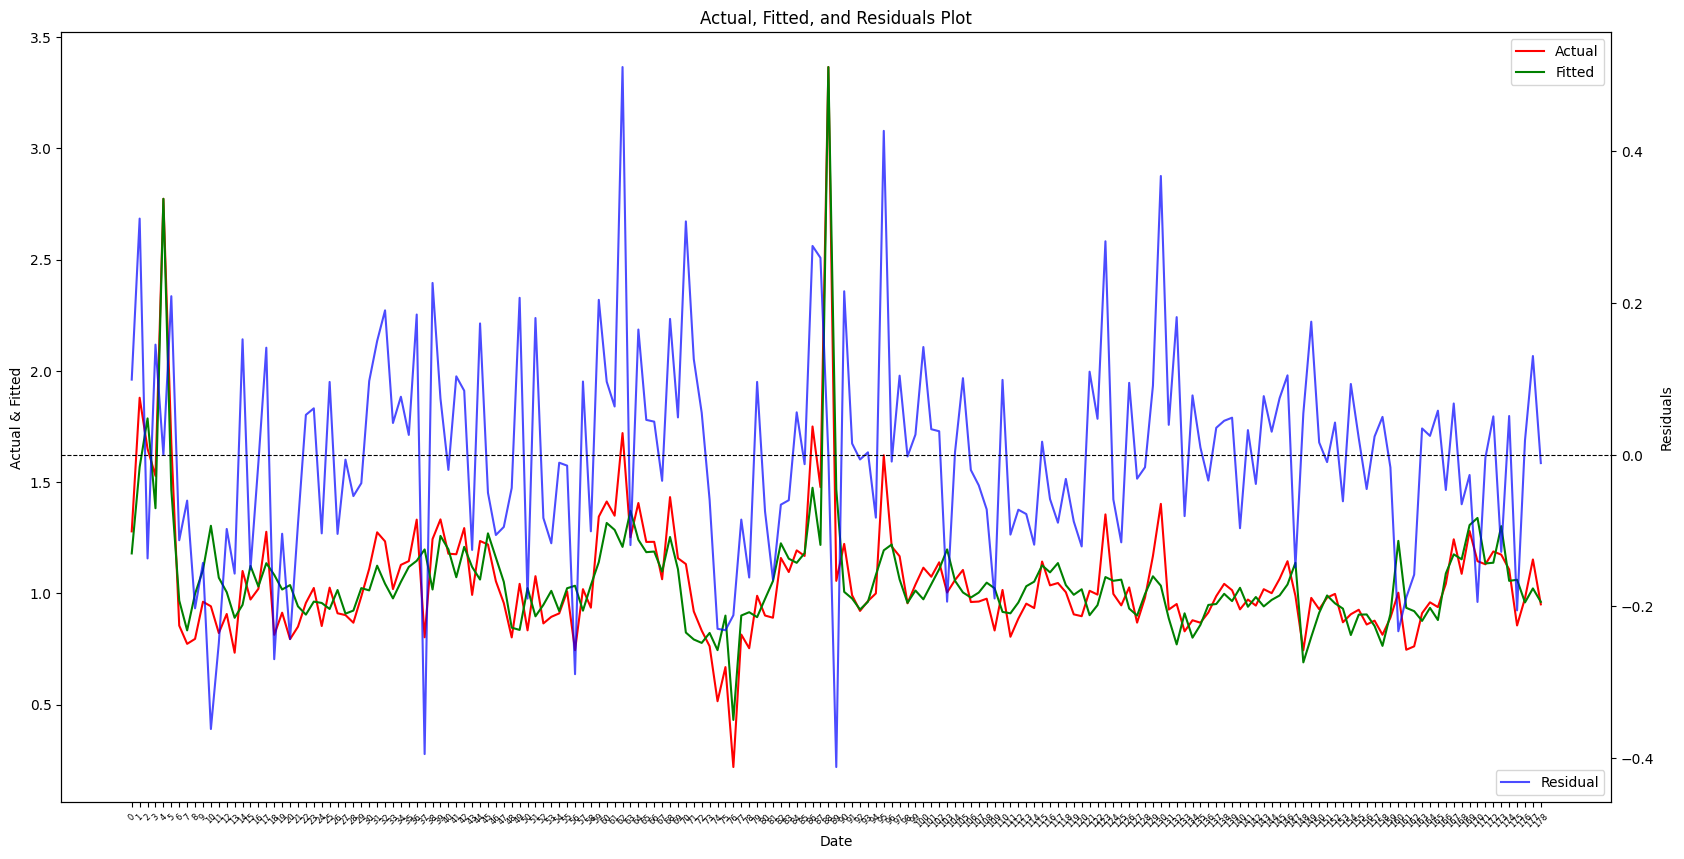

                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              2076.
Date:                Tue, 18 Feb 2025   Prob (F-statistic):                   4.77e-153
Time:                        05:33:02   Log-Likelihood:                          95.875
No. Observations:                 179   AIC:                                     -181.8
Df Residuals:                     174   BIC:                                     -165.8
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

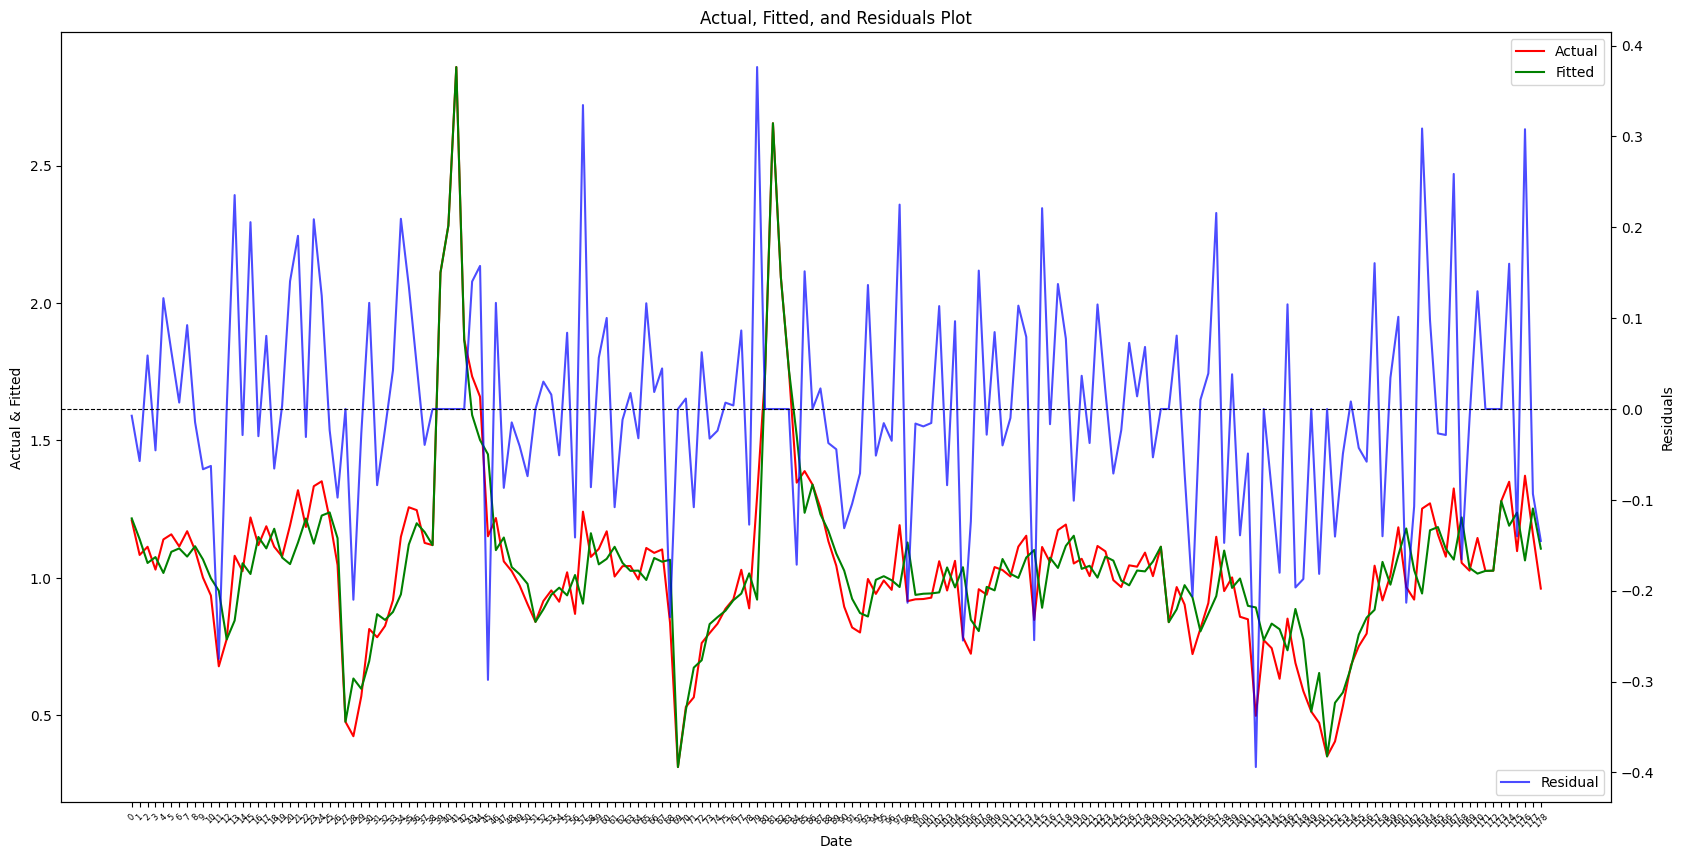

                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.986
Method:                 Least Squares   F-statistic:                              526.7
Date:                Tue, 18 Feb 2025   Prob (F-statistic):                   8.44e-136
Time:                        05:33:04   Log-Likelihood:                          123.86
No. Observations:                 179   AIC:                                     -199.7
Df Residuals:                     155   BIC:                                     -123.2
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

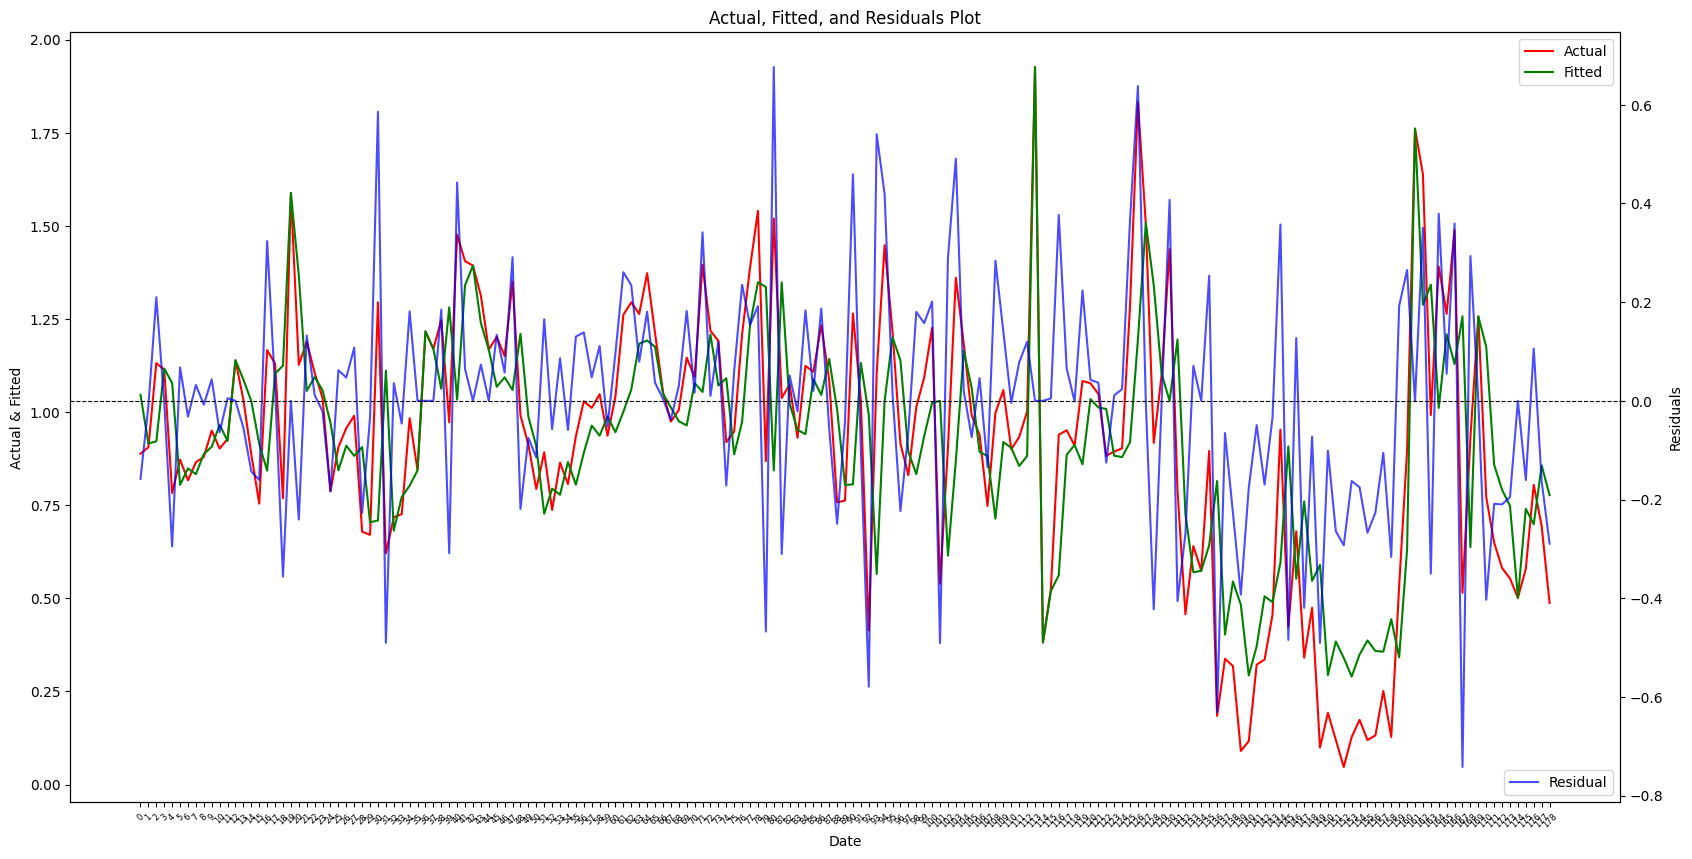

                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.942
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                              155.5
Date:                Tue, 18 Feb 2025   Prob (F-statistic):                    6.50e-91
Time:                        05:33:06   Log-Likelihood:                          2.6294
No. Observations:                 179   AIC:                                      28.74
Df Residuals:                     162   BIC:                                      82.93
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

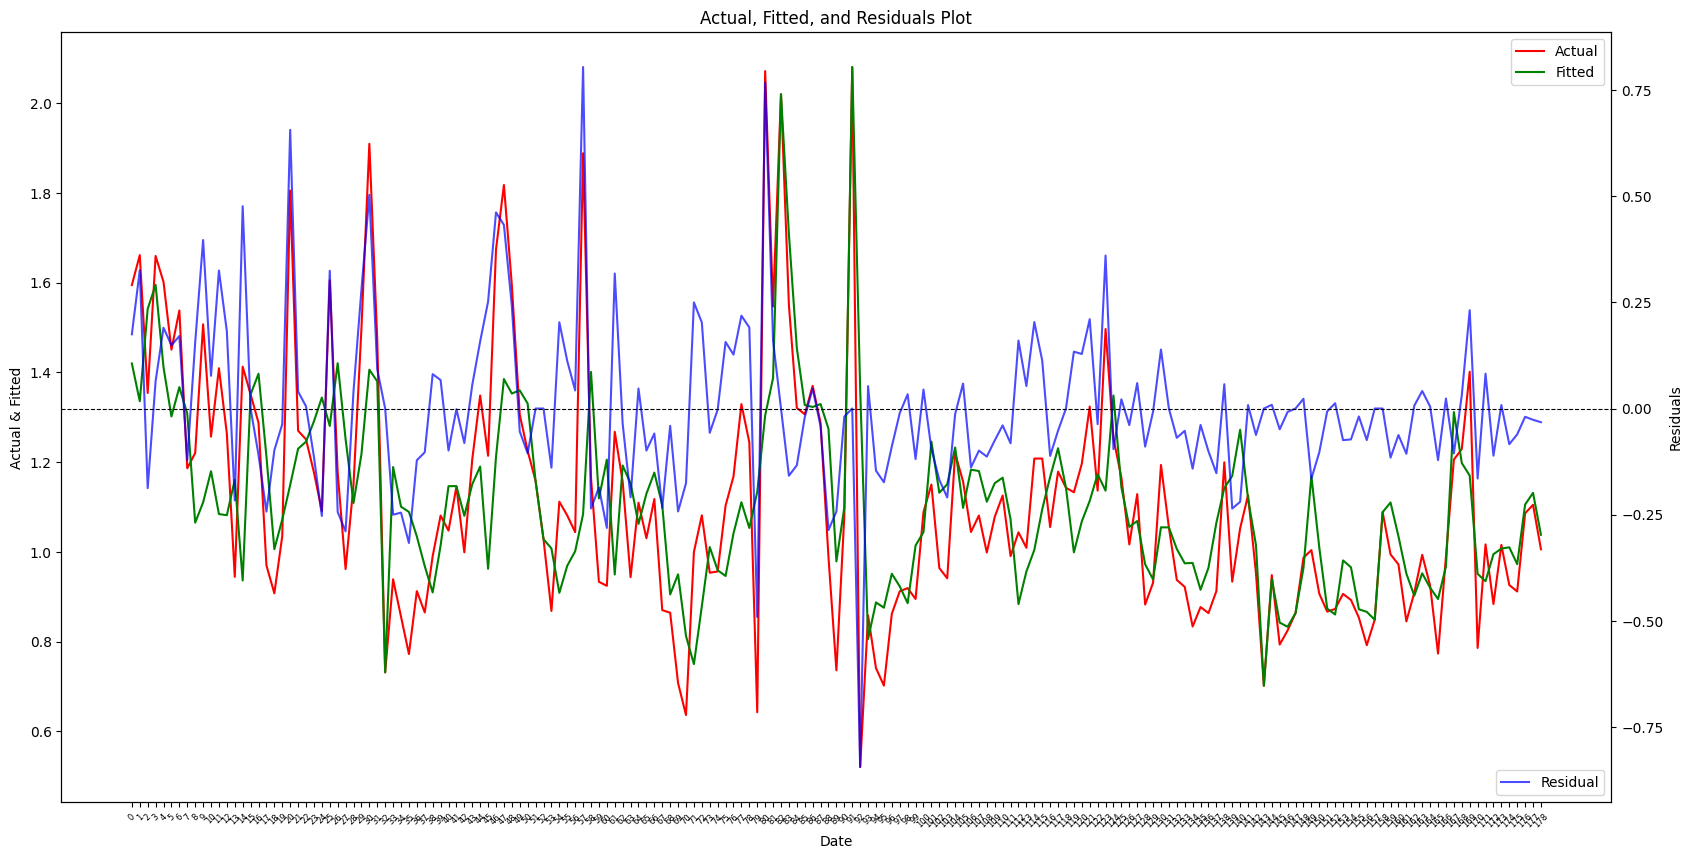

                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                              381.4
Date:                Tue, 18 Feb 2025   Prob (F-statistic):                   1.02e-117
Time:                        05:33:07   Log-Likelihood:                          35.389
No. Observations:                 179   AIC:                                     -42.78
Df Residuals:                     165   BIC:                                      1.845
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

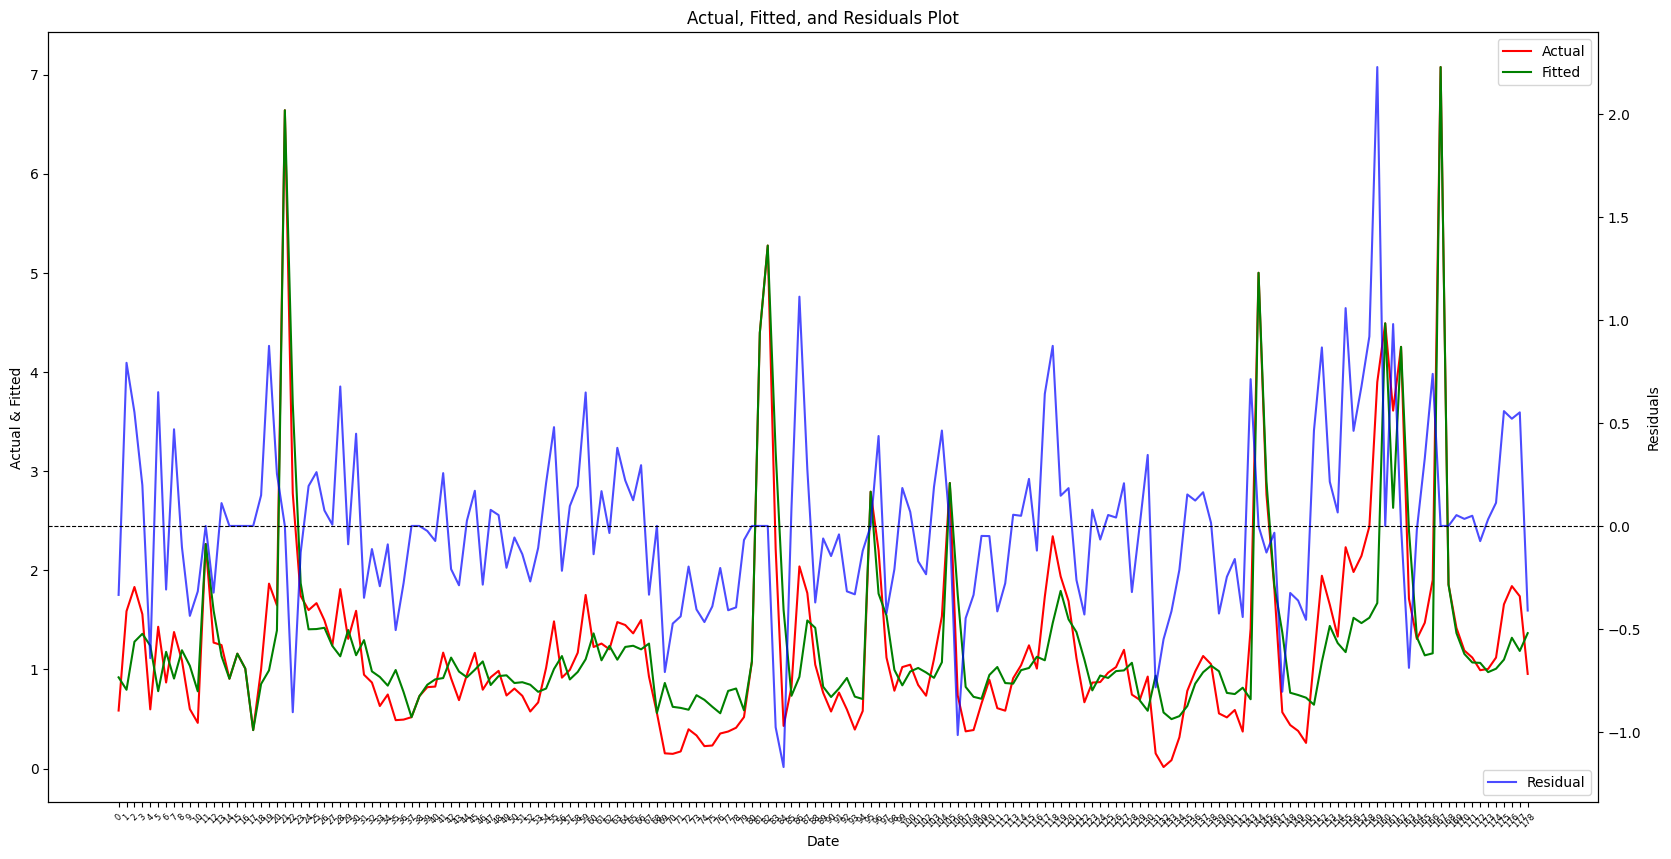

                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.934
Model:                            OLS   Adj. R-squared (uncentered):              0.924
Method:                 Least Squares   F-statistic:                              100.6
Date:                Tue, 18 Feb 2025   Prob (F-statistic):                    6.98e-81
Time:                        05:33:09   Log-Likelihood:                         -101.60
No. Observations:                 179   AIC:                                      247.2
Df Residuals:                     157   BIC:                                      317.3
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

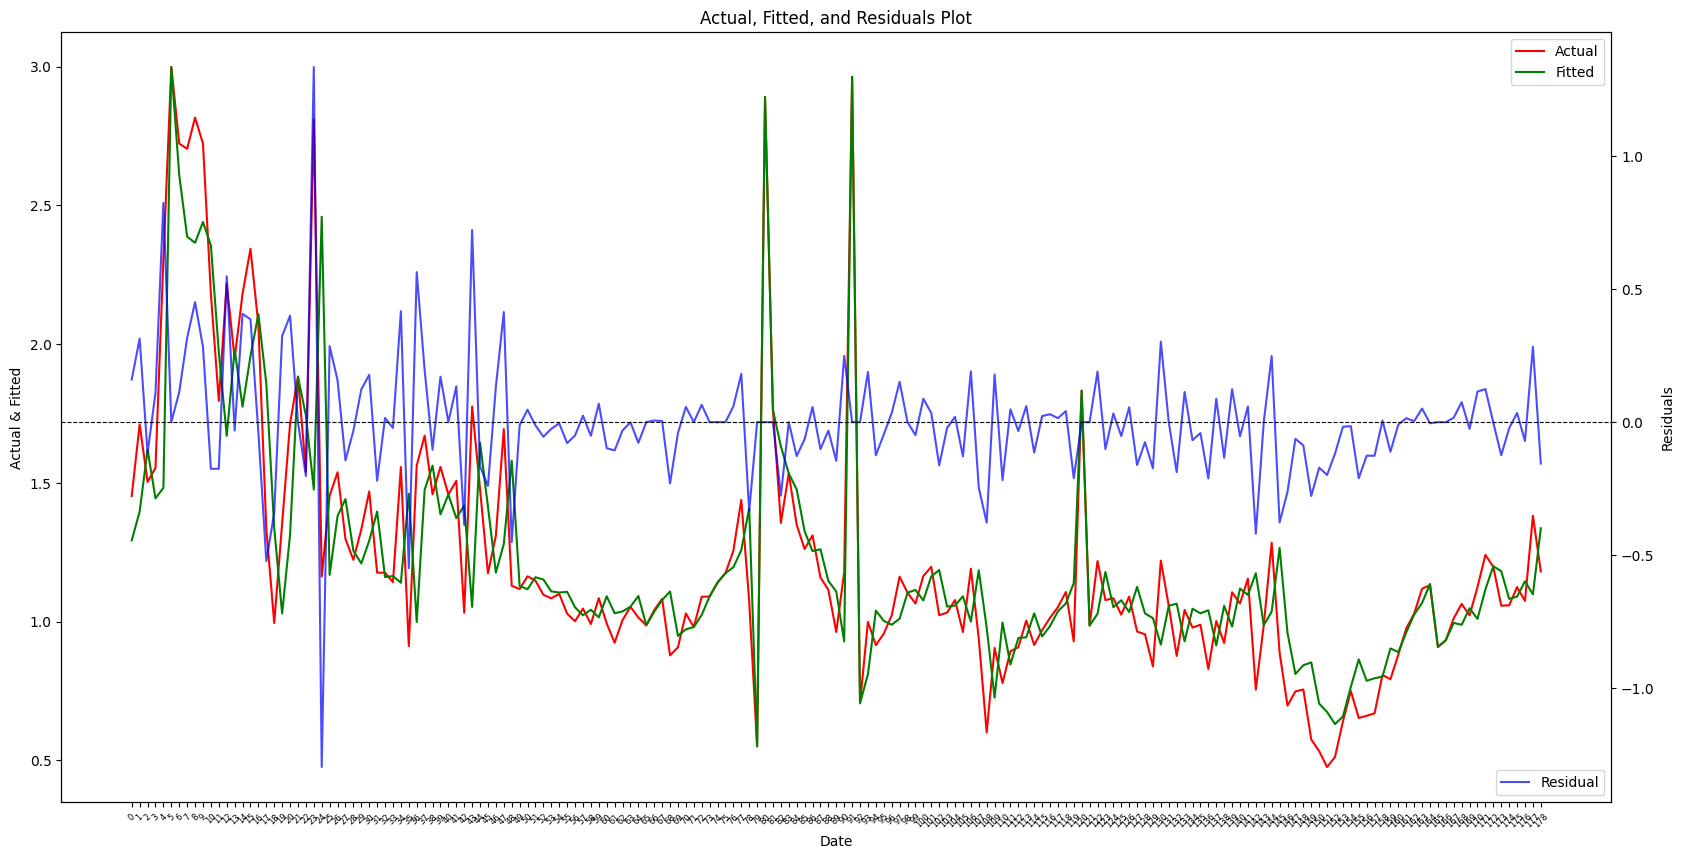

                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.961
Method:                 Least Squares   F-statistic:                              202.9
Date:                Tue, 18 Feb 2025   Prob (F-statistic):                   1.72e-103
Time:                        05:33:11   Log-Likelihood:                        -0.45225
No. Observations:                 179   AIC:                                      44.90
Df Residuals:                     157   BIC:                                      115.0
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

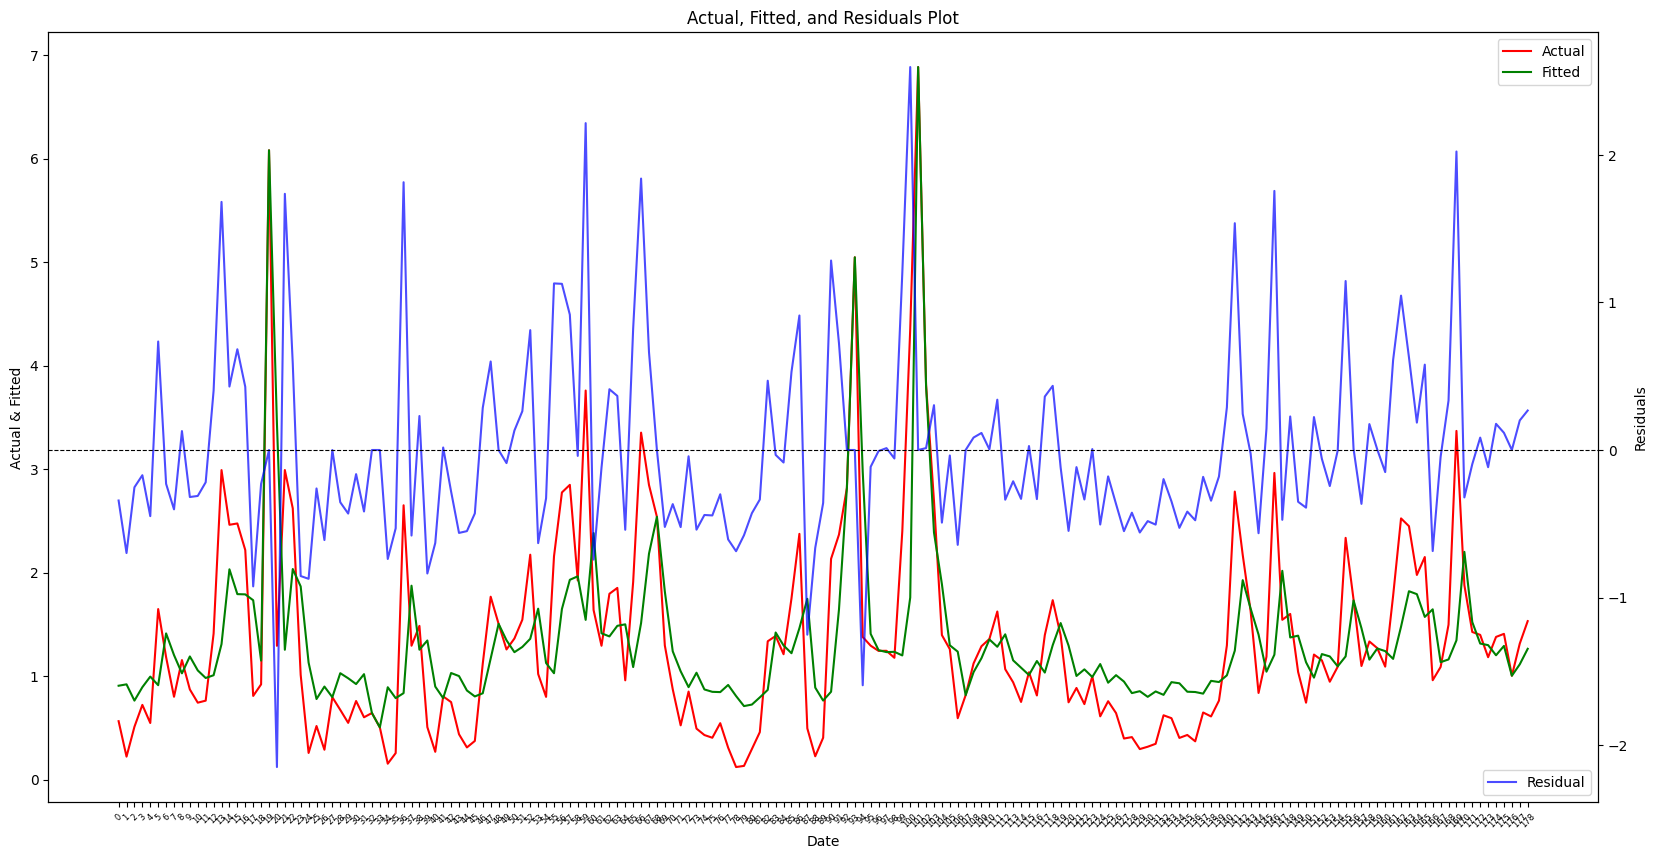

                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.848
Model:                            OLS   Adj. R-squared (uncentered):              0.836
Method:                 Least Squares   F-statistic:                              71.06
Date:                Tue, 18 Feb 2025   Prob (F-statistic):                    9.27e-61
Time:                        05:33:12   Log-Likelihood:                         -180.31
No. Observations:                 179   AIC:                                      386.6
Df Residuals:                     166   BIC:                                      428.1
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

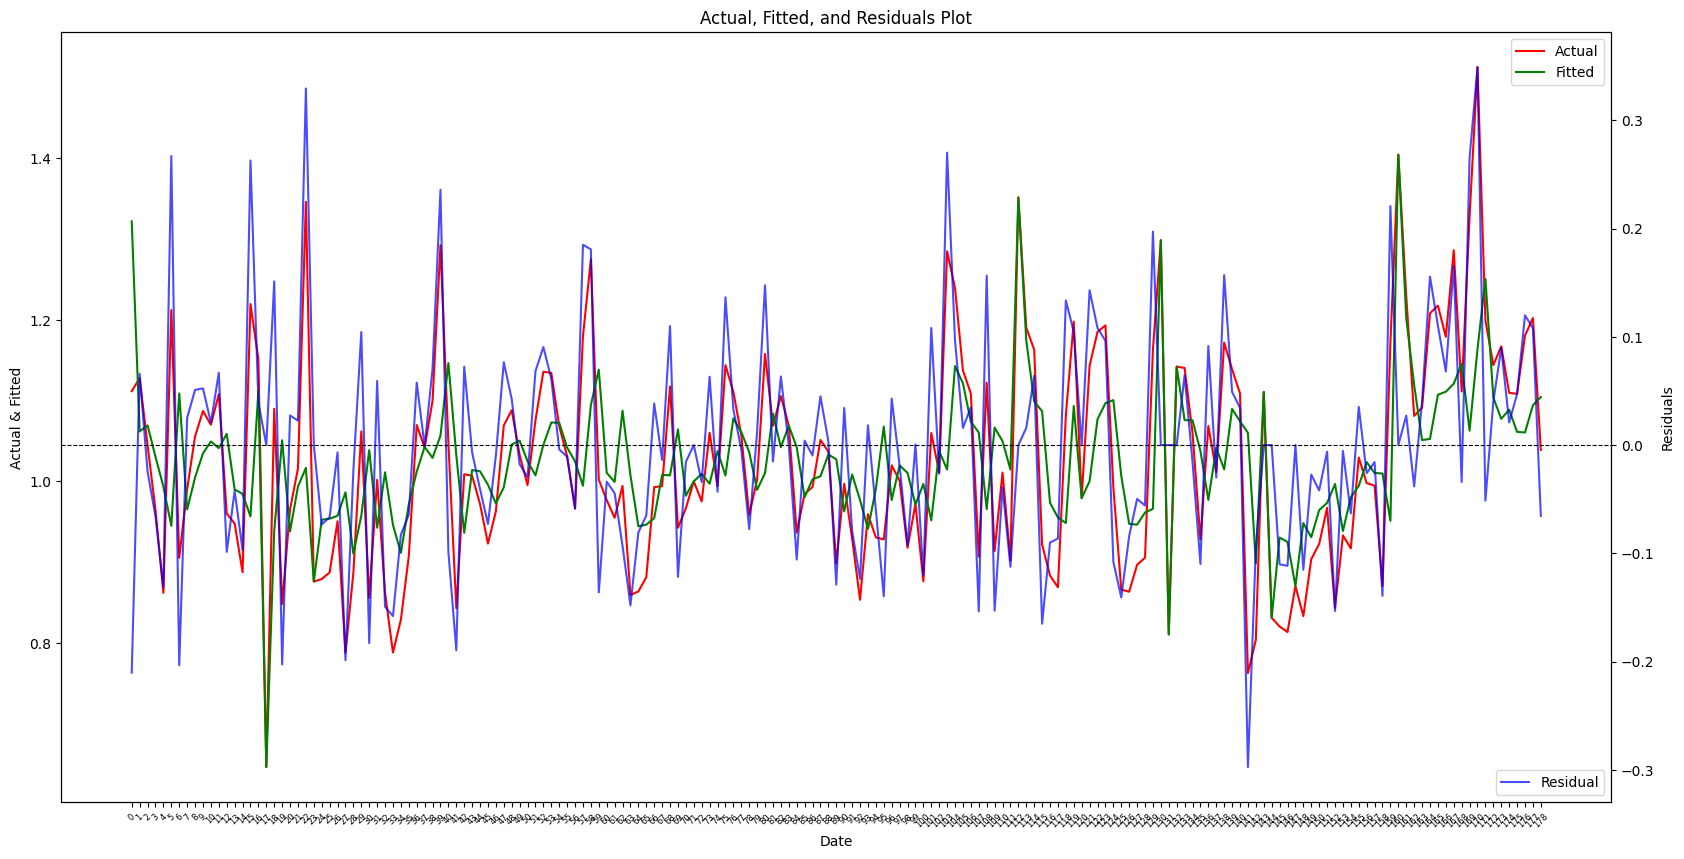

                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                              935.2
Date:                Tue, 18 Feb 2025   Prob (F-statistic):                   2.71e-151
Time:                        05:33:13   Log-Likelihood:                          145.28
No. Observations:                 179   AIC:                                     -258.6
Df Residuals:                     163   BIC:                                     -207.6
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

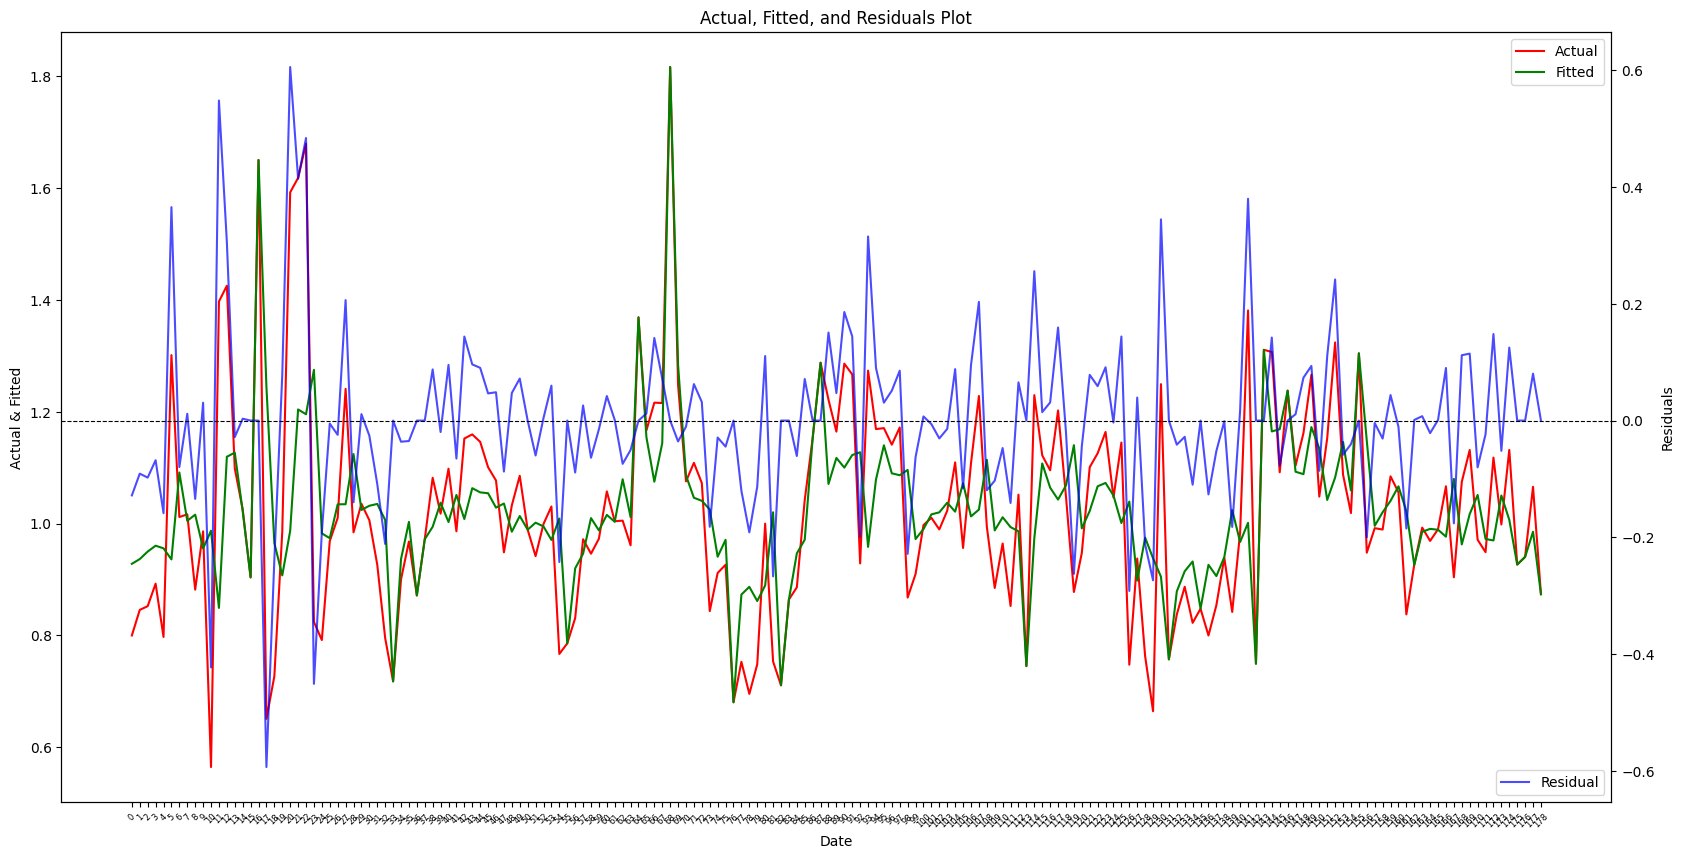

                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              255.1
Date:                Tue, 18 Feb 2025   Prob (F-statistic):                   1.04e-112
Time:                        05:33:14   Log-Likelihood:                          81.650
No. Observations:                 179   AIC:                                     -109.3
Df Residuals:                     152   BIC:                                     -23.24
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

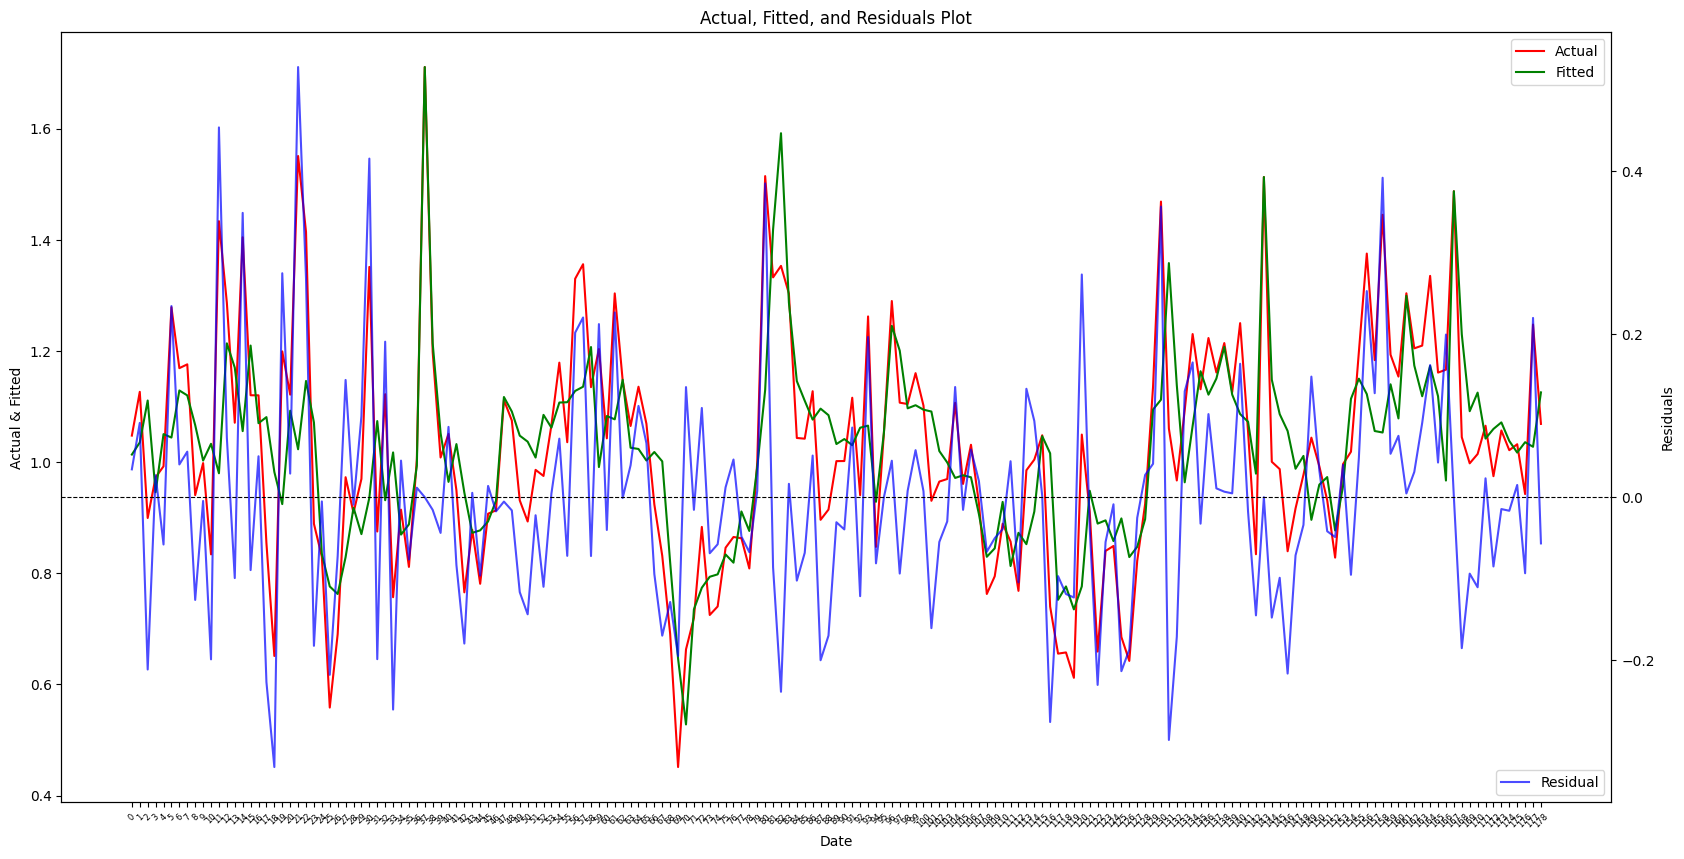

                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.980
Method:                 Least Squares   F-statistic:                              1266.
Date:                Tue, 18 Feb 2025   Prob (F-statistic):                   2.37e-144
Time:                        05:33:15   Log-Likelihood:                          91.960
No. Observations:                 179   AIC:                                     -169.9
Df Residuals:                     172   BIC:                                     -147.6
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

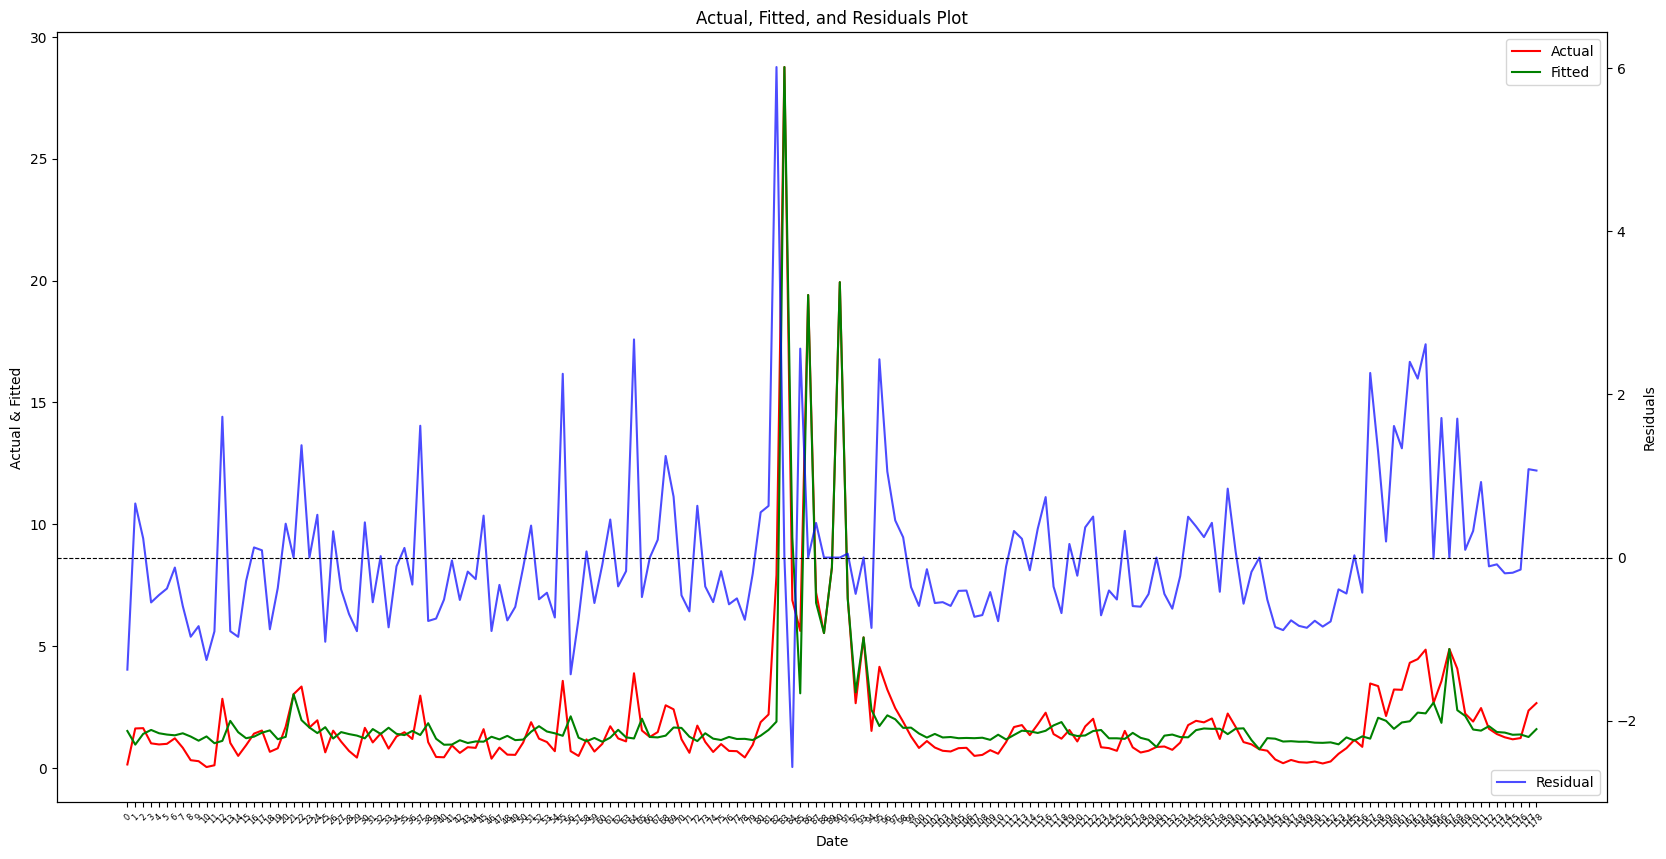

                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.935
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              157.6
Date:                Tue, 18 Feb 2025   Prob (F-statistic):                    4.94e-89
Time:                        05:33:16   Log-Likelihood:                         -244.21
No. Observations:                 179   AIC:                                      518.4
Df Residuals:                     164   BIC:                                      566.2
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

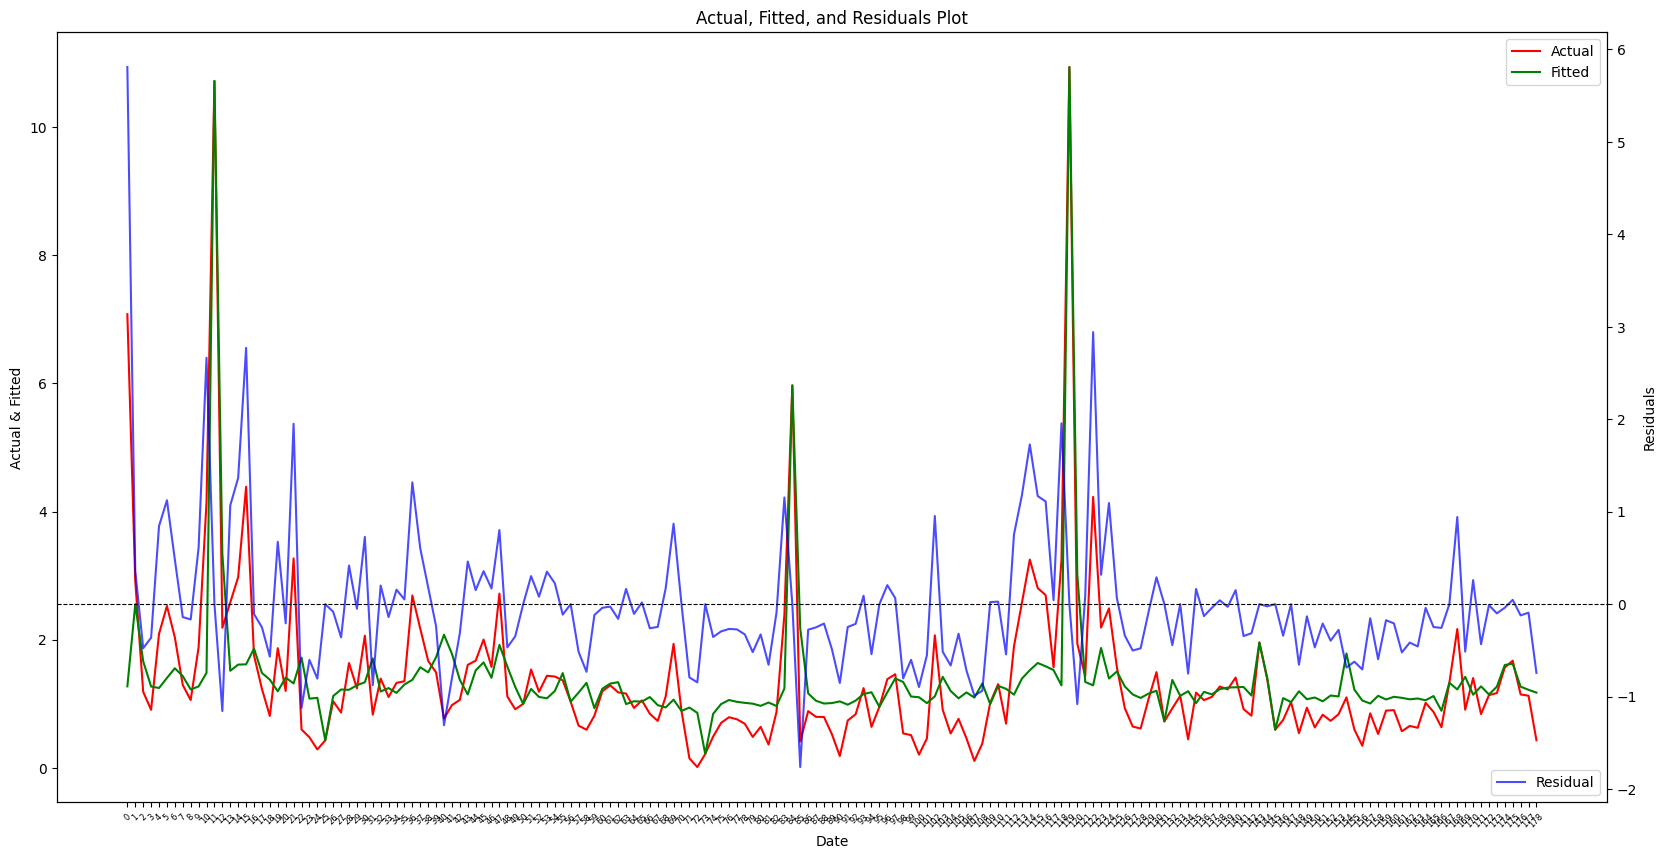

                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.830
Model:                            OLS   Adj. R-squared (uncentered):              0.811
Method:                 Least Squares   F-statistic:                              43.59
Date:                Tue, 18 Feb 2025   Prob (F-statistic):                    1.96e-52
Time:                        05:33:17   Log-Likelihood:                         -216.55
No. Observations:                 179   AIC:                                      469.1
Df Residuals:                     161   BIC:                                      526.5
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

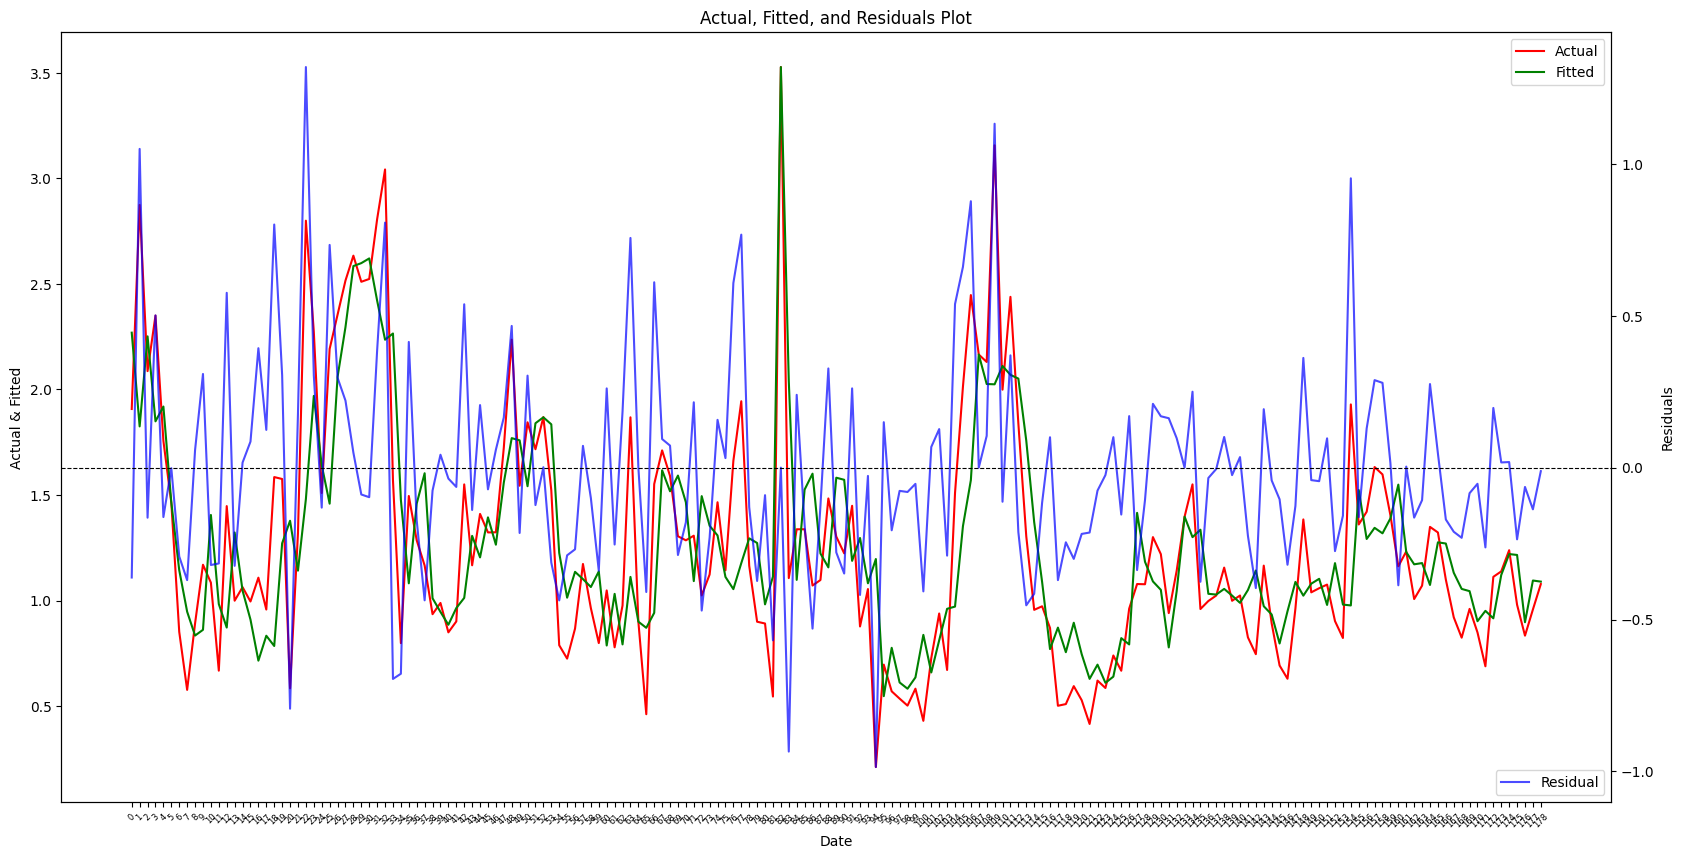

                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.934
Model:                            OLS   Adj. R-squared (uncentered):              0.932
Method:                 Least Squares   F-statistic:                              350.3
Date:                Tue, 18 Feb 2025   Prob (F-statistic):                    3.08e-98
Time:                        05:33:18   Log-Likelihood:                         -70.424
No. Observations:                 179   AIC:                                      154.8
Df Residuals:                     172   BIC:                                      177.2
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

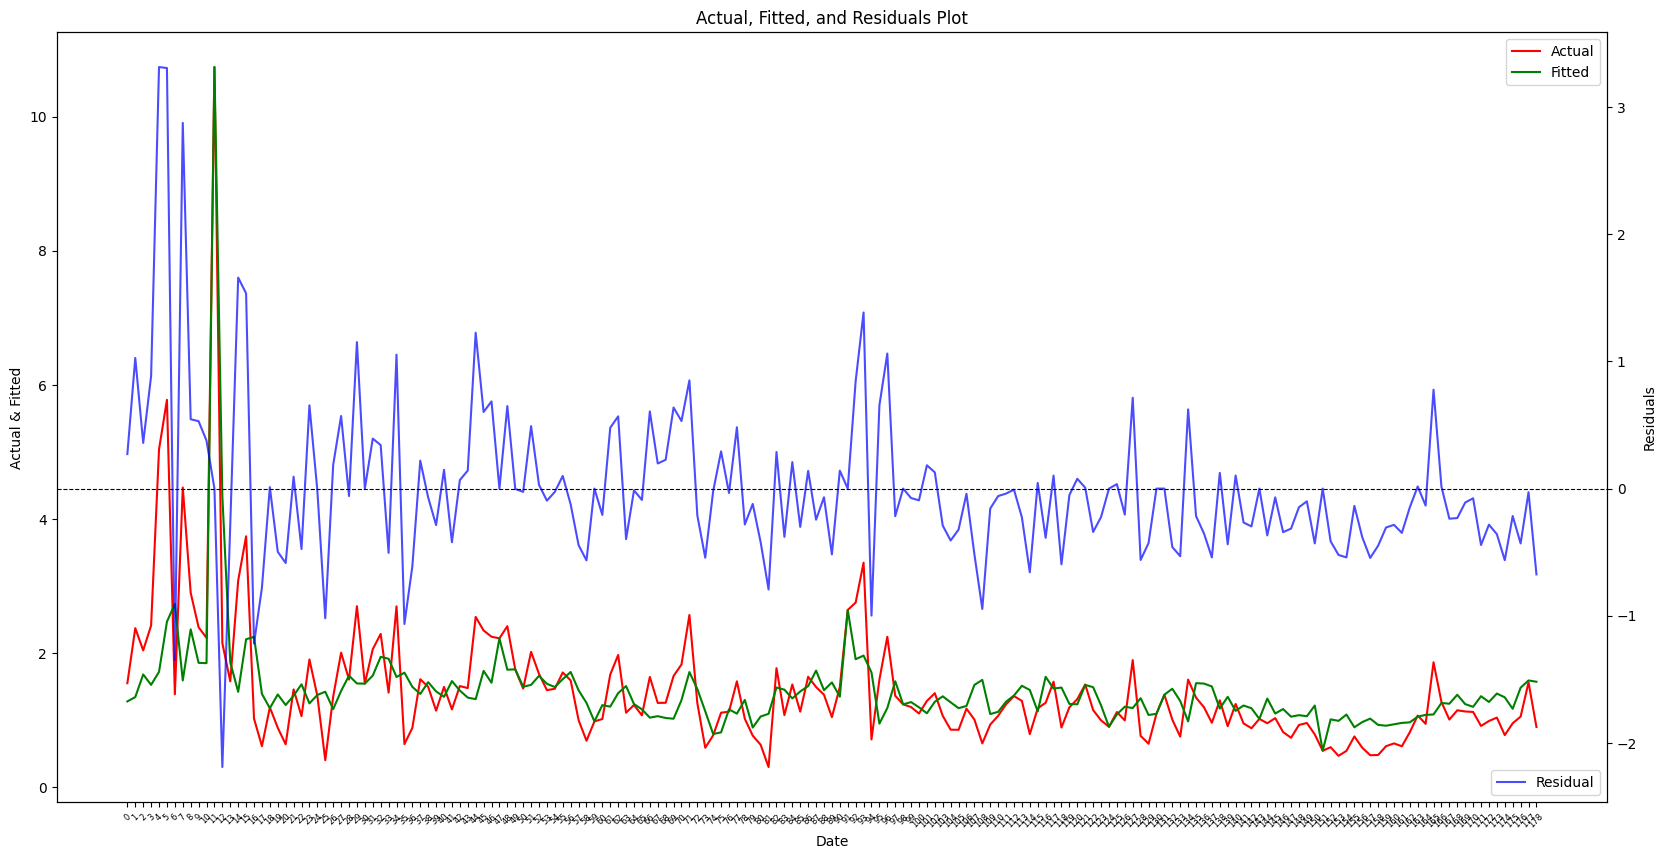

                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.862
Model:                            OLS   Adj. R-squared (uncentered):              0.850
Method:                 Least Squares   F-statistic:                              73.42
Date:                Tue, 18 Feb 2025   Prob (F-statistic):                    3.07e-63
Time:                        05:33:20   Log-Likelihood:                         -179.82
No. Observations:                 179   AIC:                                      387.6
Df Residuals:                     165   BIC:                                      432.3
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [50]:
for commodity_type in df_transportation_volumes.index:

  type_dct = {
      "date": df_transportation_volumes.columns,
      "Y": df_transportation_volumes.loc[commodity_type],   # Transport Volume Growth Index
      "T": df_transportation_tariff.loc[commodity_type],   # Tariff growth index
      "X": df_volumes.loc[commodity_type]   # Production growth index
  }
  # dummy variables
  dct_serial_data = construct_serial_data_by_type(commodity_type, df_volumes, dct_serial)
  for key, value in dct_serial_data.items():
    type_dct[key] = value

  df_type = pd.DataFrame(type_dct)

  df_type["Y_lag"] = df_type["Y"].shift(1)

  df_type = df_type.dropna()

  Y = df_type["Y"]
  lst_data = [i for i in df_type.columns if i != 'Y' and i != 'date']
  X = df_type[[i for i in df_type.columns if i in lst_data]]
  df_type.set_index('date', inplace=True)
  # Adding a constant for regression
  # X = sm.add_constant(X)

  # Make regression
  model = sm.OLS(Y, X).fit()

  print("**********************************************************************************")
  print("commodity type:", commodity_type)

  # correlation_matrix = df_type.corr()
  # print(correlation_matrix)
  # Print results
  plot_regression_results(model, df_type)
  print(model.summary())